# Projet d'analyse de fraude

Par Théo DESLAGE et Maximilien GOMAS

## Exploration et visualisation des données

On peut constater que les données sont divisées en deux ensembles :
- Le premier, labelisé, servira à l'apprentissage supervisé (Entrainement et test)
- Le second, inconnu, représente une situation réelle dans laquelle nous devrons prédire à l'aide de notre modèle

Chargeons les données

In [3]:
fraudes <- read.csv("./data/Data_Projet_1.csv", header = TRUE, sep = ",", dec = ".", stringsAsFactors = TRUE)
head(fraudes)

,claim_id,customer_id,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
,<int>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>
1,54004764,21868593,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,No
2,33985796,75740424,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,No
3,53522022,30308357,27,Female,Other driver error,4,Auto,No,Material only,3369.5,1,Yes
4,13015401,47830476,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,No
5,22890252,19269962,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,No
6,24050443,21831191,36,Male,Other driver error,2116,Auto,No,Injury only,38306.5,3,Yes


Nous allons maintenant explorer les données et comprendre quelles features sont déterminantes pour la prédiction de la fraude.

### Summary pour se donner une vue globale

In [4]:
summary(fraudes)

    claim_id         customer_id            age          gender   
 Min.   :   26832   Min.   :  154557   Min.   :18.0   Female:541  
 1st Qu.:23815805   1st Qu.:26791756   1st Qu.:33.0   Male  :559  
 Median :48539331   Median :49855152   Median :47.0               
 Mean   :48838190   Mean   :50874698   Mean   :47.8               
 3rd Qu.:74074466   3rd Qu.:75949511   3rd Qu.:63.0               
 Max.   :99775483   Max.   :99961993   Max.   :79.0               
            incident_cause days_to_incident  claim_area police_report
 Crime             :110    Min.   :    2.0   Auto:985   No     :630  
 Driver error      :262    1st Qu.:  635.5   Home:115   Unknown:300  
 Natural causes    :189    Median : 2042.5              Yes    :170  
 Other causes      :290    Mean   : 2814.1                           
 Other driver error:249    3rd Qu.: 4153.5                           
                           Max.   :14991.0                           
               claim_type   claim_amount 

In [5]:
table(fraudes$fraudulent)


 No Yes 
846 254 

On se rend compte que les fraudes sont très minoritaires il va donc falloir travailler sur ce dataset avant de l'entrainer

### Recherche sur l'age

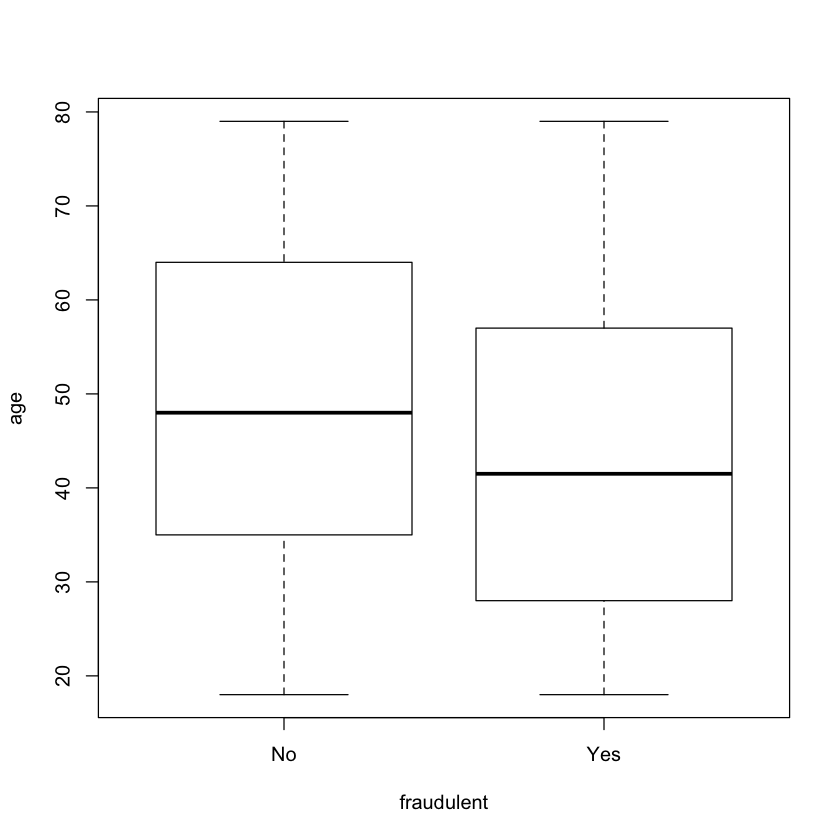

In [6]:
boxplot(age~fraudulent, data=fraudes)

On peut constater que les déclarations frauduleuses concernent un publique plus jeune que celles qui ne le sont pas.

### Recherche par rapport au montant déclaré

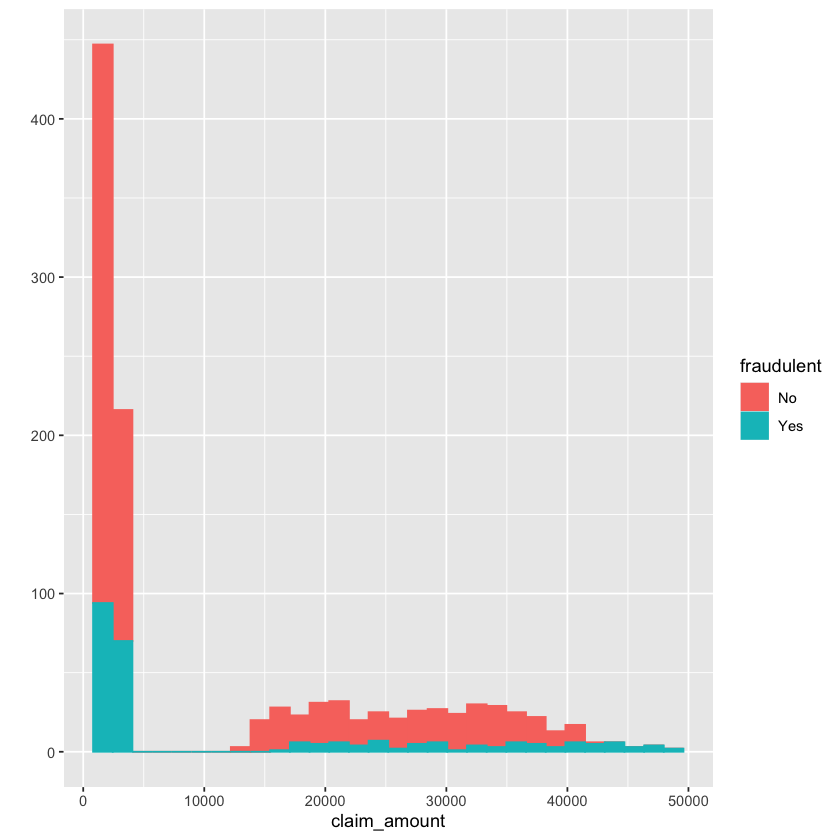

In [7]:
library(ggplot2)
qplot(claim_amount, data=fraudes, color=fraudulent, fill=fraudulent,bins = 30)

On décide de séparer les claim_amount (supérieur et inférieur à 10000) pour mieux visualiser les tendances.

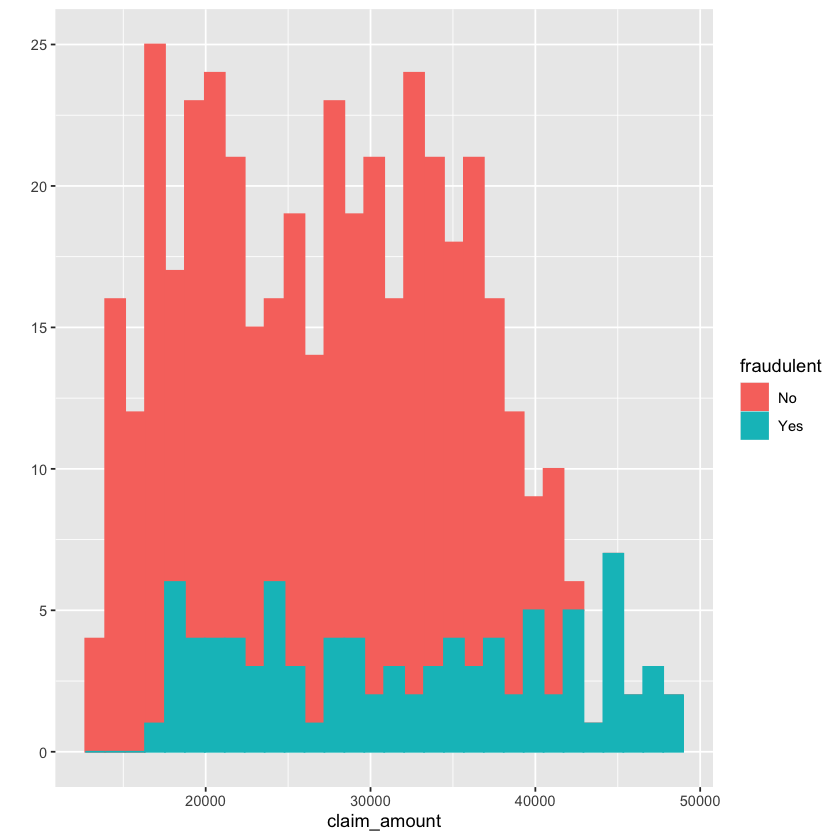

In [8]:
library(ggplot2)
qplot(claim_amount, data=fraudes[fraudes$claim_amount>10000,], color=fraudulent, fill=fraudulent, bins = 30)

On remarque qu'au dessus de 43k, toutes les ransactions sont frauduleuses. Nous décidons d'enlever les valeurs au dessus de 43k lors du pré traitement des données, car notre arbre fera inéluctablement une corrélation qui nous semble plus lié au jeu de donnée qu'à une représentation de la réalité.

Pour confirmer notre raisonnement on compte le nombre de transactions concernées, et on se rend compte que c'est assez faible (15/1100)

In [9]:
nrow(fraudes)
nrow(fraudes[fraudes$claim_amount>43000,])

[1] 1100

[1] 15

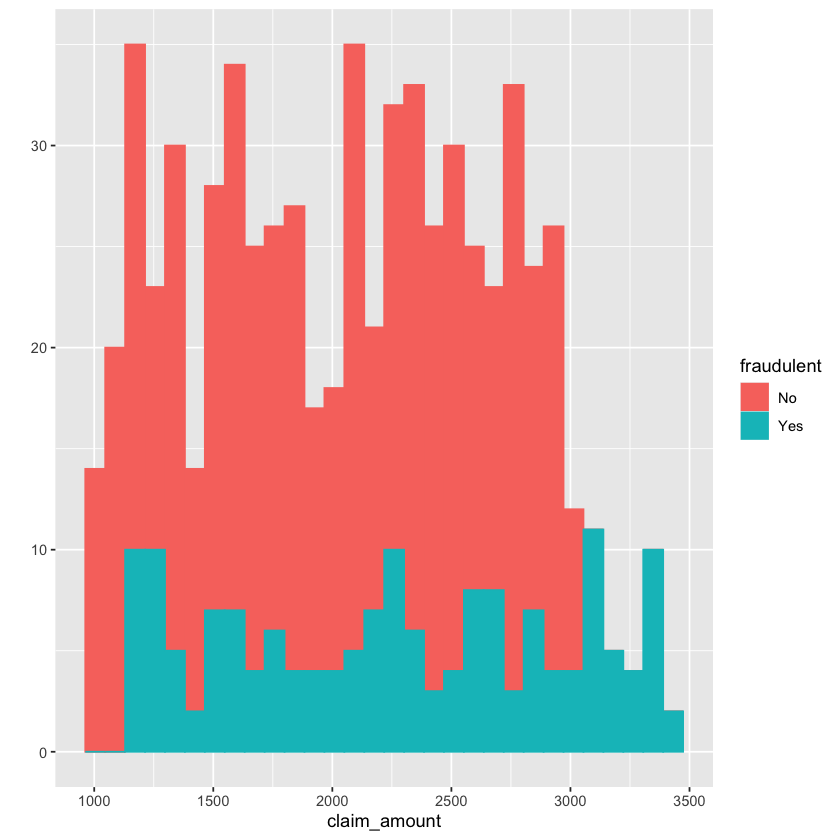

In [10]:
qplot(claim_amount, data=fraudes[fraudes$claim_amount<10000,], color=fraudulent, fill=fraudulent, bins = 30)

Il y a l'air d'avoir plus de fraudes à moins de 10k

### Recherche par rapport au genre

On se permet de comparer car grâce à la summarization on a pu constater que le nombre d'échantillon pour chaque sexe était relativement le même.

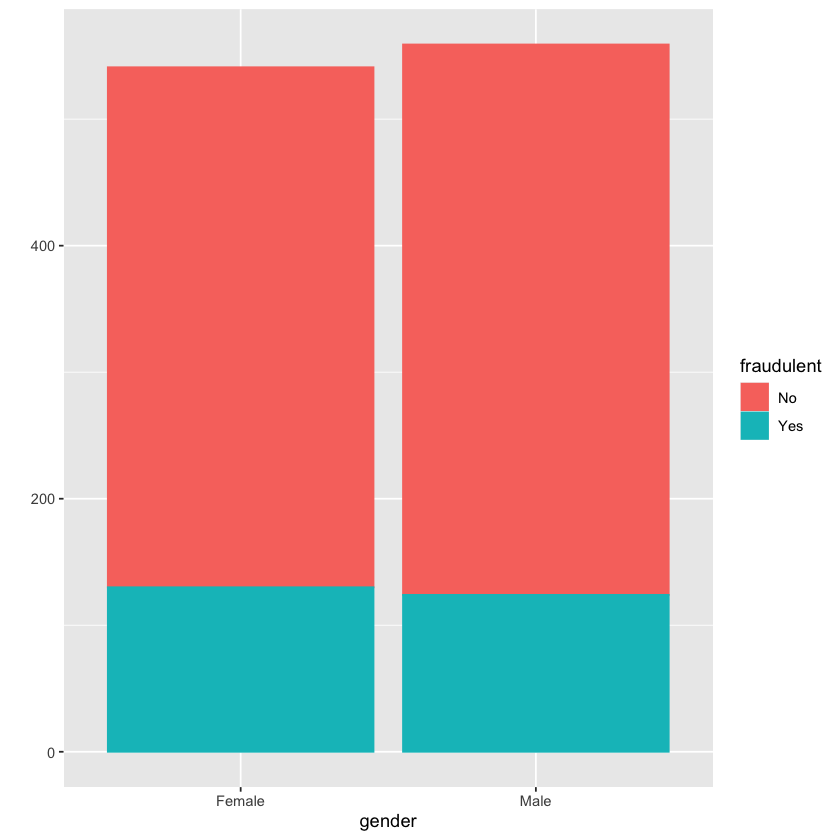

In [11]:
qplot(gender, data=fraudes, color=fraudulent, fill=fraudulent)

On constate que le genre n'influe pas du tout sur le caractère frauduleux d'une transaction

### La cause de l'incident

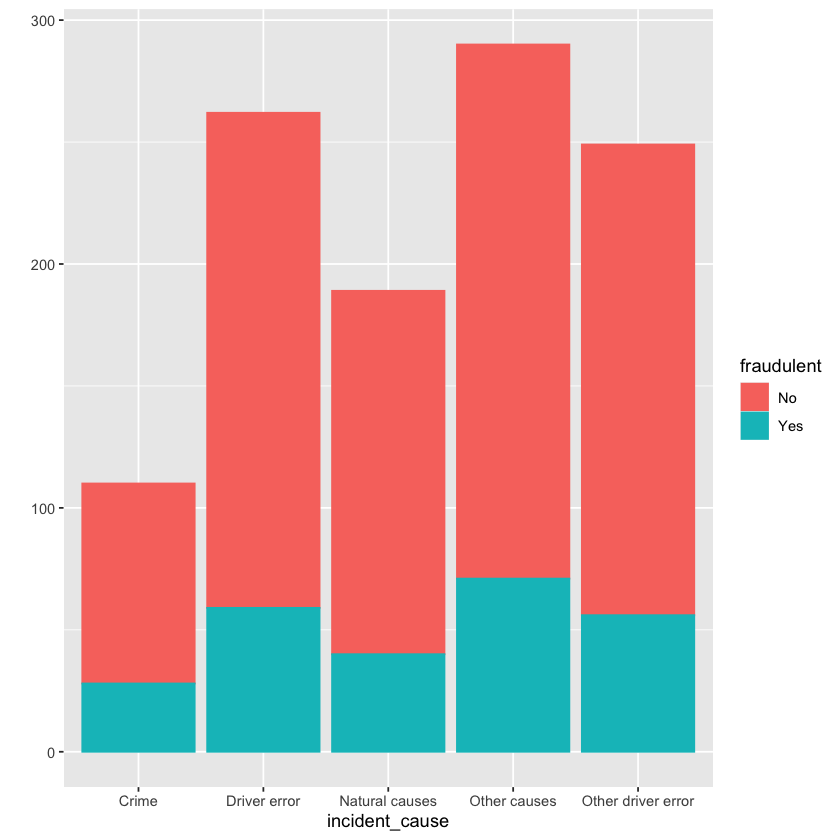

In [12]:
qplot(incident_cause, data=fraudes, color=fraudulent, fill=fraudulent)

On constate que la cause de l'incident ne joue pas beaucoup non plus sur le caractère frauduleux

### Nombre de jours passés entre l'incident et la déclaration

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



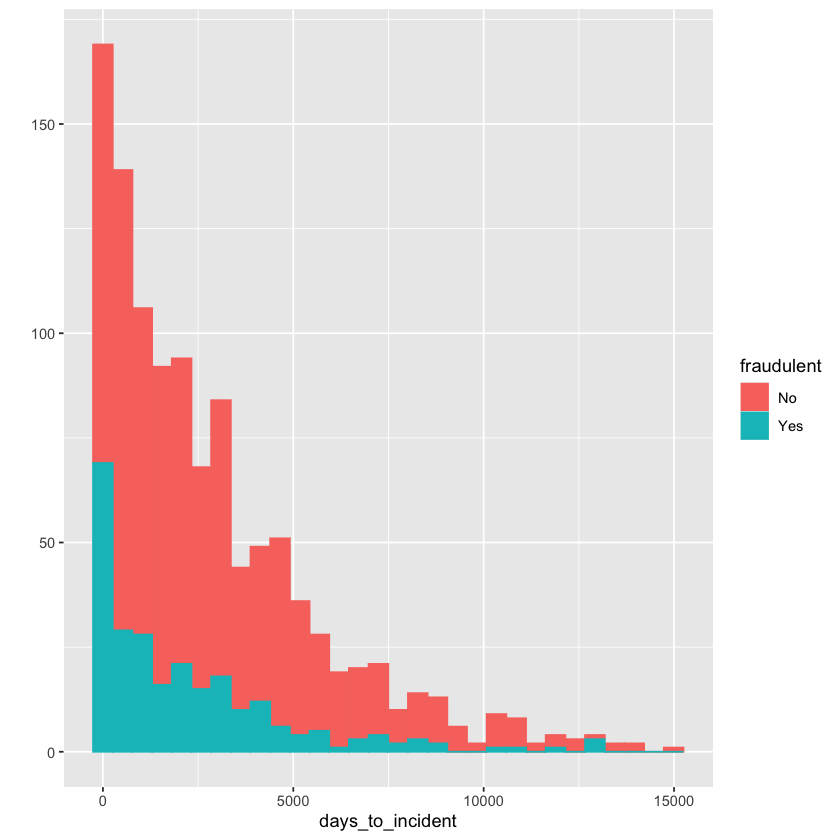

In [13]:
qplot(days_to_incident, data=fraudes, color=fraudulent, fill=fraudulent)

On remarque qu'il y a une proportion de fraudes plus élevée pour les incidents déclarés immédiatements. On confirme :

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



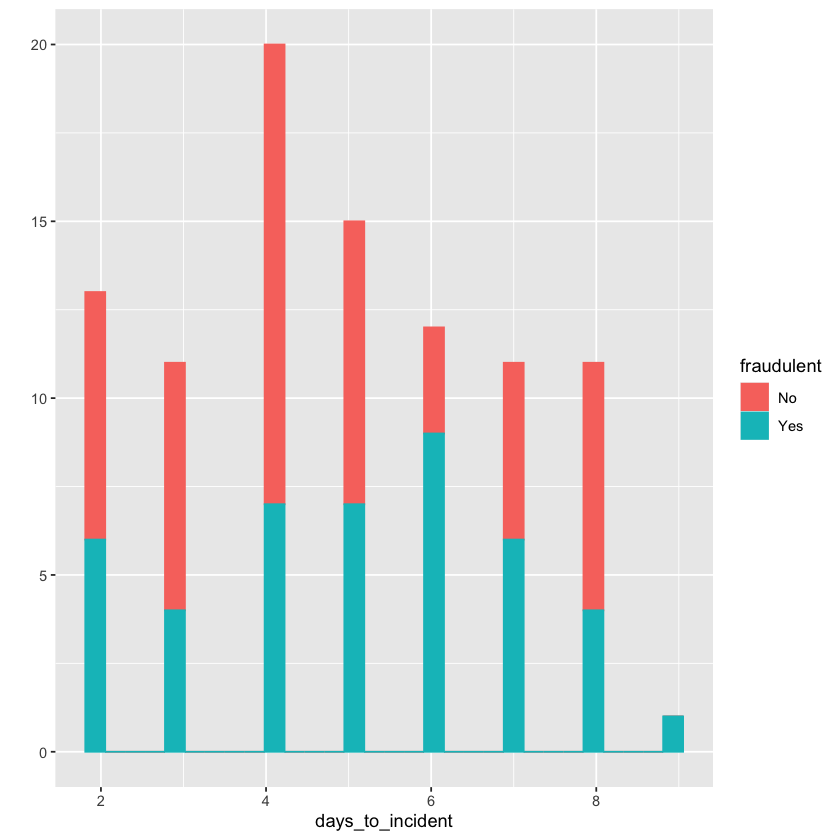

In [14]:
# Incidents déclarés en moins de 10 jours
qplot(days_to_incident, data=fraudes[fraudes$days_to_incident<10,], color=fraudulent, fill=fraudulent)

In [15]:
print(nrow(fraudes[fraudes$days_to_incident<10 & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$days_to_incident<10,]))
print(nrow(fraudes[fraudes$fraudulent=='Yes',])/nrow(fraudes))

[1] 0.4680851
[1] 0.2309091


Cela veut dire que pour des déclarations faites à moins de 10 jours on a 46% de fraude ce qui est nettement superieur à l'ensemble global (23%). Ce critère sera donc très intéressant pour notre modèle.

### La zone de déclaration

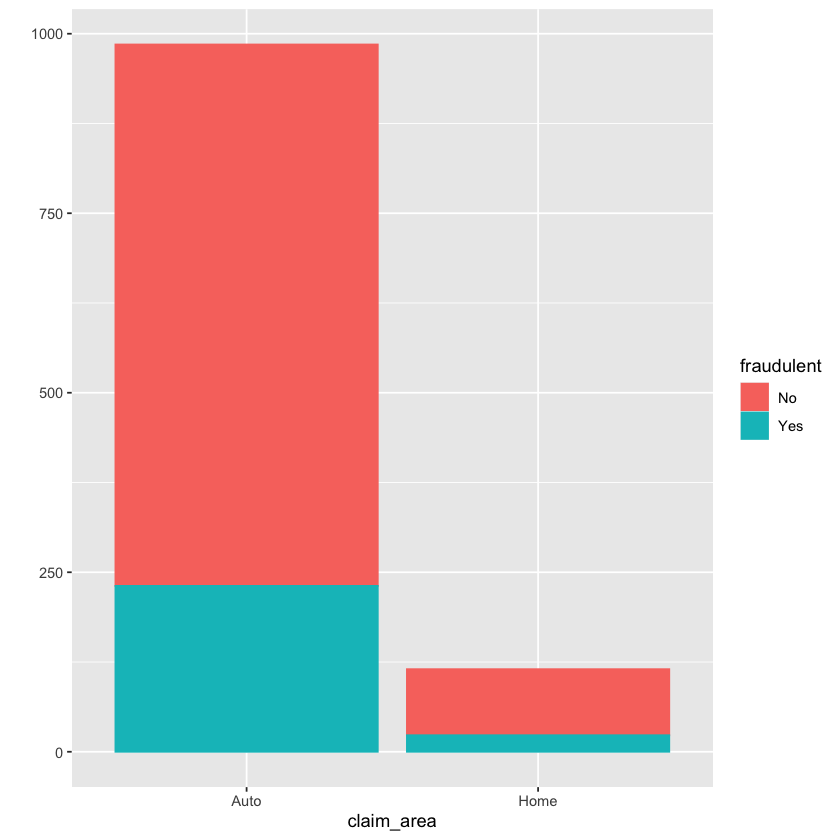

In [16]:
qplot(claim_area, data=fraudes, color=fraudulent, fill=fraudulent)

### Un rapport de police

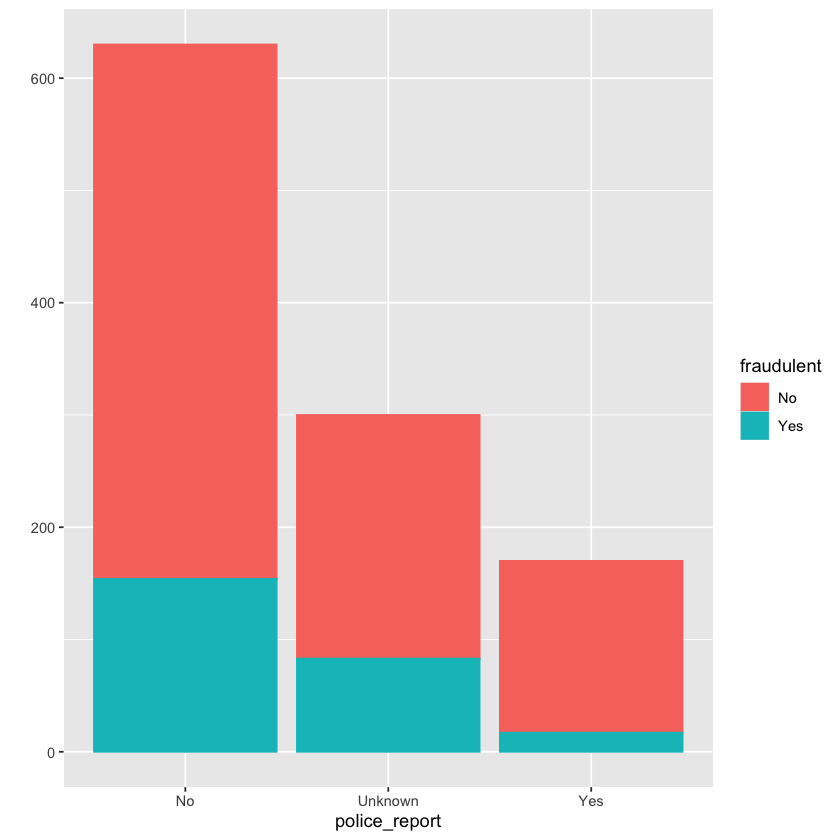

In [17]:
qplot(police_report, data=fraudes, color=fraudulent, fill=fraudulent)

On pressent une information intéressante, on compare donc les 3 cas (avec le global qui est de 23%)

In [18]:
print(nrow(fraudes[fraudes$police_report=='Yes' & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$police_report=='Yes',])) # Rapport
print(nrow(fraudes[fraudes$police_report=='Unknown' & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$police_report=='Unknown',])) # Unknown
print(nrow(fraudes[fraudes$police_report=='No' & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$police_report=='No',])) # No Report

[1] 0.1
[1] 0.2766667
[1] 0.2444444


On constate que lors de la réalisation d'un rapport il n'y a que 10% de fraudes, ça influe donc très négativement (positivement pour l'assureur) sur les fraudes.

### Le type de déclaration

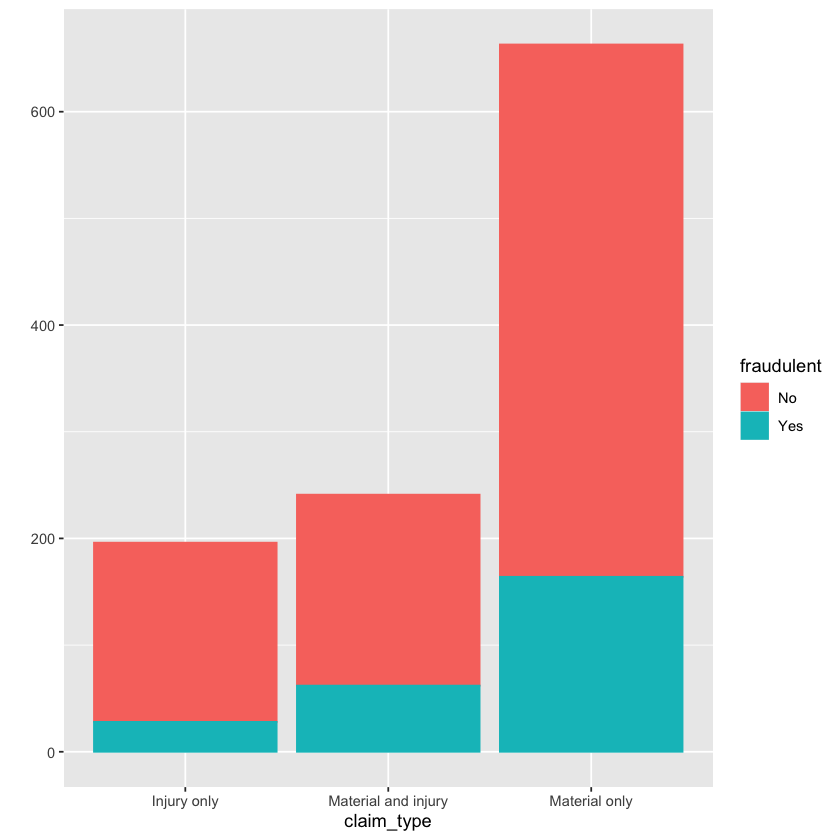

In [19]:
qplot(claim_type, data=fraudes, color=fraudulent, fill=fraudulent)

### Nombre d'incidents déclarés

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



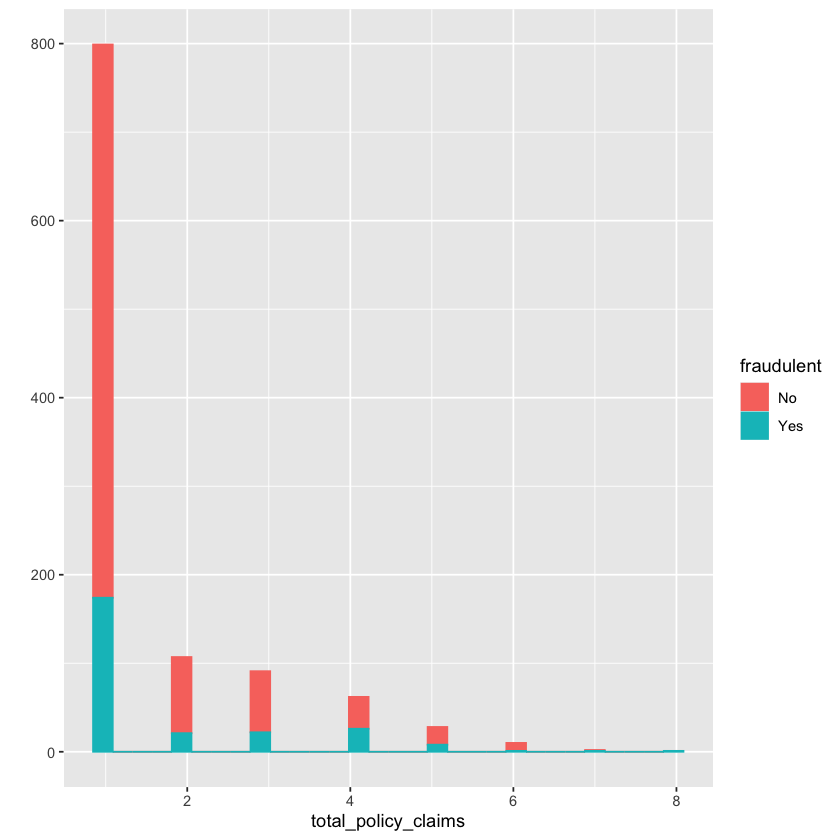

In [20]:
qplot(total_policy_claims, data=fraudes, color=fraudulent, fill=fraudulent) 

Pour chaque total policy claim de 1 à 8, on affiche, la taille de l'échantillon et le pourcentage de fraude

In [21]:
print(nrow(fraudes[fraudes$total_policy_claims==2 & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$total_policy_claims==2,])) 
nrow(fraudes[fraudes$total_policy_claims==1,])

for (x in 1:8) {
    print("------")
    print(nrow(fraudes[fraudes$total_policy_claims==x,]))
    pct <- nrow(fraudes[fraudes$total_policy_claims==x & fraudes$fraudulent=='Yes',])/nrow(fraudes[fraudes$total_policy_claims==x,])*100
    print(pct)
} 

[1] 0.1962617


[1] 799

[1] "------"
[1] 799
[1] 21.77722
[1] "------"
[1] 107
[1] 19.62617
[1] "------"
[1] 91
[1] 24.17582
[1] "------"
[1] 62
[1] 41.93548
[1] "------"
[1] 28
[1] 28.57143
[1] "------"
[1] 10
[1] 10
[1] "------"
[1] 2
[1] 50
[1] "------"
[1] 1
[1] 100


In [22]:
print(fraudes[fraudes$total_policy_claims>6,])

    claim_id customer_id age gender     incident_cause days_to_incident
52  39647651    18361978  73 Female       Other causes             4770
820 42530425    46129941  29 Female              Crime             1274
875 32759962    77116501  68 Female Other driver error             2820
    claim_area police_report          claim_type claim_amount
52        Auto       Unknown Material and injury      25576.0
820       Auto            No       Material only       3277.5
875       Auto       Unknown         Injury only      20490.0
    total_policy_claims fraudulent
52                    7        Yes
820                   8        Yes
875                   7         No


Il n'y a que très peu de données pour les policy claims == 7 ou 8, on décidera donc de les enlever

## Pré traitement des données

On sait que deux variables ne sont pas pertinentes dans la prédiction, l'ID de la transaction *claim_id* puisqu'il est unique et le numéro d'utilisateur *customer_id*. On pourrait établir un modèle qui prend en compte le *customer_id* pour "suspecter" ceux qui ont déjà fraudé. Mais dans ce cas de la détection de nouvelles fraudes l'utilisateur sera très probablement nouveau, il ne faut pas que cela altère le jugement du modèle, qui doit se méfier de tout le monde, sans distinction.

In [23]:
# On filtre selon ce qu'on avait décidé sur le claim_amount
fraudes <- fraudes[fraudes$claim_amount<43000,]
# On supprime le claim_id et le customer_id
fraudes <- fraudes[,-c(1:2)]
head(fraudes)

,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<fct>
1,32,Female,Driver error,225,Auto,No,Material only,2980.0,1,No
2,60,Female,Crime,11874,Home,Unknown,Material only,2980.0,3,No
3,27,Female,Other driver error,4,Auto,No,Material only,3369.5,1,Yes
4,39,Female,Natural causes,5278,Auto,No,Material only,1680.0,1,No
5,47,Male,Crime,2335,Auto,No,Material only,2680.0,1,No
6,36,Male,Other driver error,2116,Auto,No,Injury only,38306.5,3,Yes


## Définition de la méthode d'évaluation des classifieurs

Nous allons utiliser les 3 arbres vus en cours (tree, C5.0 et rpart) et nous allons essayer avec toutes les features, puis seulement avec celles que nous avons identifiées comme pertinentes suite à notre phase exploratoire.

fraudes -> toutes

fraudes_P -> seulement celles pertinentes

## Définition des données d'apprentissage et de test

In [24]:
featuresPertinentes <- c('age', 'claim_amount', 'days_to_incident', 'incident_cause', 'police_report', 'claim_type', 'total_policy_claims', 'fraudulent')

t <- nrow(fraudes)/3*2
max <- nrow(fraudes)

# (2/3) apprentissage
fraudes_EA <- fraudes[1:t,-c(1,2)]
# seulement pertinentes
fraudes_EA_P <- fraudes[1:t, featuresPertinentes]

# (1/3) test
fraudes_ET <- fraudes[t:max,-c(1,2)]
# Seulement pertinentes
fraudes_ET_P <- fraudes[t:max, featuresPertinentes]

table(fraudes_EA$fraudulent)
table(fraudes_ET$fraudulent)


 No Yes 
566 157 


 No Yes 
281  81 

### Réduire les transactions non frauduleuses

Comme prévu on va équilibrer les transactions frauduleuses et non frauduleuses **de l'ensemble d'apprentissage** pour que notre arbre ne soit pas trop orienté sur l'ensemble prédominant (No)

In [25]:
# cut x rows

dfYes <- fraudes_EA[fraudes_EA$fraudulent=='Yes',]
print(nrow(dfYes))
dfNo <- fraudes_EA[fraudes_EA$fraudulent=='No',]
# Delete some no transactions
dfNo <- tail(dfNo, -350)

# On fusionne les deux dataframes
fraudes_EA <- rbind(dfYes, dfNo)

table(fraudes_EA$fraudulent)


[1] 157



 No Yes 
216 157 

In [26]:
print(nrow(fraudes_EA))
# shuffle dataset
fraudes_EA <- fraudes_EA[sample(1:nrow(fraudes_EA)),]
print(nrow(fraudes_EA))

[1] 373
[1] 373


## Construction et évaluation du classifieur

On applique une cost matrix pour l'apprentissage des arbres, définie comme suit : une prédiction vraie coûte 0, Yes prédit false (une fraude qui passe) coûte 4 fois plus cher que de payer une personne pour reclassifier un true en false (faux positif). On imagine que ce sont des données qui nous sont transmises par l'assurance.

Il est de toute façon très facile de changer cette matrice si besoin

In [27]:
costmatrix <- matrix(c(0,1,4,0), byrow = TRUE, nrow = 2)
costmatrix

0,1
4,0


### Analyse avec toutes les features

In [28]:
library(rpart)
library(C50)
library(tree)

Registered S3 method overwritten by 'tree':
  method     from
  print.tree cli 



In [29]:
tree1 <- rpart(fraudulent ~ ., fraudes_EA, parms = list(loss = costmatrix))
tree2 <- C5.0(fraudulent ~ ., fraudes_EA)
tree3 <- tree(fraudulent ~ ., fraudes_EA)

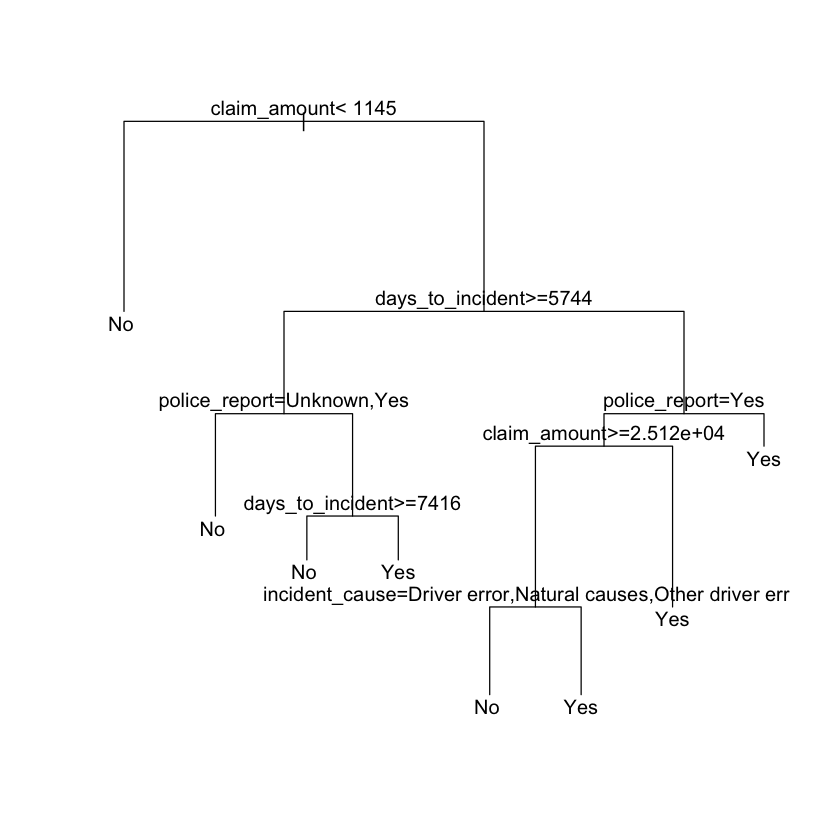

In [30]:
plot(tree1)
text(tree1, pretty=0)

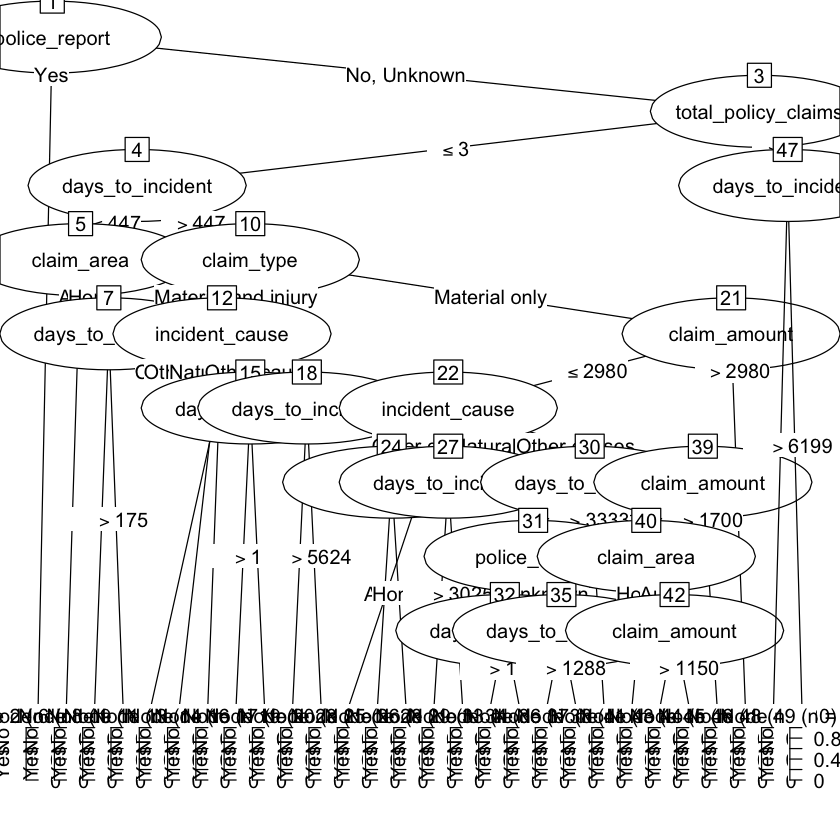

In [31]:
plot(tree2)

In [32]:
test_tree1 <- predict(tree1, fraudes_ET, type="class")
test_tree2 <- predict(tree2, fraudes_ET, type="class")
test_tree3 <- predict(tree3, fraudes_ET, type="class")

Matrices de confusion

In [33]:
mc_tree1 = table(fraudes_ET$fraudulent, test_tree1)
mc_tree2 = table(fraudes_ET$fraudulent, test_tree2)
mc_tree3 = table(fraudes_ET$fraudulent, test_tree3)
print(mc_tree1)
print(mc_tree2)
print(mc_tree3)

     test_tree1
       No Yes
  No   57 224
  Yes  13  68
     test_tree2
       No Yes
  No  188  93
  Yes  38  43
     test_tree3
       No Yes
  No  250  31
  Yes  57  24


In [34]:
fraudes_ET$Prediction1 <- test_tree1
fraudes_ET$Prediction2 <- test_tree2
fraudes_ET$Prediction3 <- test_tree3

On calcul le success rate (Yes prédit Yes) et la précision

In [35]:
perf <- function(tree, mc_tree, predictColumn) {
    correct <- (mc_tree[1,1]+mc_tree[2,2])/(mc_tree[1,1]+mc_tree[2,2]+mc_tree[1,2]+mc_tree[2,1])
    cat("Precision : ",correct)
    print('')
    taux_success <- mc_tree[2,2]/(mc_tree[2,2]+mc_tree[2,1])
    print("Taux succes (YES predit YES) :")
    print(taux_success)
} 

In [36]:
perf(tree1, mc_tree1)
perf(tree2, mc_tree2)
perf(tree3, mc_tree3)

Precision :  0.3453039[1] ""
[1] "Taux succes (YES predit YES) :"
[1] 0.8395062
Precision :  0.6381215[1] ""
[1] "Taux succes (YES predit YES) :"
[1] 0.5308642
Precision :  0.7569061[1] ""
[1] "Taux succes (YES predit YES) :"
[1] 0.2962963


### Analyse avec seulement les features pertinentes

In [37]:
library(rpart)
library(C50)
library(tree)
head(fraudes_EA_P)

,age,claim_amount,days_to_incident,incident_cause,police_report,claim_type,total_policy_claims,fraudulent
,<int>,<dbl>,<int>,<fct>,<fct>,<fct>,<int>,<fct>
1,32,2980.0,225,Driver error,No,Material only,1,No
2,60,2980.0,11874,Crime,Unknown,Material only,3,No
3,27,3369.5,4,Other driver error,No,Material only,1,Yes
4,39,1680.0,5278,Natural causes,No,Material only,1,No
5,47,2680.0,2335,Crime,No,Material only,1,No
6,36,38306.5,2116,Other driver error,No,Injury only,3,Yes


In [38]:
tree1 <- rpart(fraudulent ~ ., fraudes_EA_P, parms = list(loss = costmatrix))
tree2 <- C5.0(fraudulent ~ ., fraudes_EA_P)
tree3 <- tree(fraudulent ~ ., fraudes_EA_P)

In [39]:
tree1$variable.importance

days_to_incident                 age        claim_amount      incident_cause 
          47.664194           23.908272           18.172872           12.793883 
      police_report          claim_type total_policy_claims 
          10.612422            8.405942            6.554469

In [40]:
test_tree1 <- predict(tree1, fraudes_ET_P, type="class")
test_tree2 <- predict(tree2, fraudes_ET_P, type="class")
test_tree3 <- predict(tree3, fraudes_ET_P, type="class")

Matrices de confusion

In [41]:
mc_tree1 = table(fraudes_ET_P$fraudulent, test_tree1)
mc_tree2 = table(fraudes_ET_P$fraudulent, test_tree2)
mc_tree3 = table(fraudes_ET_P$fraudulent, test_tree3)
print(mc_tree1)
print(mc_tree2)
print(mc_tree3)

     test_tree1
       No Yes
  No  161 120
  Yes  33  48
     test_tree2
       No Yes
  No  264  17
  Yes  66  15
     test_tree3
       No Yes
  No  271  10
  Yes  77   4


In [42]:
perf(tree1, mc_tree1)
perf(tree2, mc_tree2)
perf(tree3, mc_tree3)

Precision :  0.5773481[1] ""
[1] "Taux succes (YES predit YES) :"
[1] 0.5925926
Precision :  0.7707182[1] ""
[1] "Taux succes (YES predit YES) :"
[1] 0.1851852
Precision :  0.7596685[1] ""
[1] "Taux succes (YES predit YES) :"
[1] 0.04938272


In [43]:
table(fraudes_ET_P$fraudulent)


 No Yes 
281  81 

## Choix du classifieur le plus performant

On constate qu'avec les features séléctionnées le premier arbre est plus performant en terme de success rate.

In [44]:
perf(tree1, mc_tree1)

Precision :  0.5773481[1] ""
[1] "Taux succes (YES predit YES) :"
[1] 0.5925926


## Application du classifieur aux données à prédire

In [111]:
dataNew <- read.csv("./data/Data_Projet_1_New.csv", header = TRUE, sep = ",", dec = ".", stringsAsFactors = TRUE)
head(dataNew)

,claim_id,customer_id,age,gender,incident_cause,days_to_incident,claim_area,police_report,claim_type,claim_amount,total_policy_claims
,<int>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>
1,99799736,99976445,69,Female,Other driver error,3655,Auto,Yes,Injury only,26130.0,1
2,99785303,99980399,72,Female,Natural causes,2867,Auto,No,Material only,2710.0,1
3,99929746,99995453,79,Female,Driver error,730,Auto,No,Injury only,40951.5,1
4,99854605,99995097,46,Male,Other driver error,5542,Auto,Yes,Material and injury,41320.0,5
5,99967261,99969333,35,Female,Other causes,1522,Auto,Unknown,Material and injury,34780.0,3
6,99796052,99975162,54,Male,Other causes,6862,Auto,No,Material only,1920.0,2


On applique le classifieur tree1 à l'ensemble à prédire dataNew à l'aide de la fonction predict()

In [127]:
pred_tree1 <- predict(tree1, dataNew, type="prob")
pred2_tree1 <- predict(tree1, dataNew, type="class")
head(pred_tree1)


,No,Yes
1,0.8977273,0.10227273
2,0.9687500,0.03125000
3,1.0000000,0.00000000
4,0.9322034,0.06779661
5,0.6621622,0.33783784
6,0.9322034,0.06779661


On ajoute au data frame dataNew une nouvelle colonne Prediction contenant la prédiction
(classe Oui ou classe Non) 

In [122]:
dataNew$ProbaNo <- pred_tree1[,1]
dataNew$ProbaYes <- pred_tree1[,2]
dataNew$Prediction <- pred2_tree1

In [124]:
dataFinal <- dataNew[, c("customer_id", "Prediction", "ProbaYes", "ProbaNo")]

head(dataFinal)

,customer_id,Prediction,ProbaYes,ProbaNo
,<int>,<fct>,<dbl>,<dbl>
1,99976445,No,0.10227273,0.8977273
2,99980399,No,0.03125000,0.9687500
3,99995453,No,0.00000000,1.0000000
4,99995097,No,0.06779661,0.9322034
5,99969333,Yes,0.33783784,0.6621622
6,99975162,No,0.06779661,0.9322034


Nous pensons que notre matrice de coûts rend le modèle plus sensible au fraudes (ProbaYes). C'est pour cela que la classe prédite ne dépasse pas forcément 50%

In [126]:
write.csv(dataFinal,"./data/Data_Projet_Predict.csv", row.names = FALSE)
